<a href="https://www.kaggle.com/code/mikedelong/python-eda?scriptVersionId=136667978" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
df = pd.concat([
    pd.read_csv(filepath_or_buffer='../input/meterology/casual.csv'),
    pd.read_csv(filepath_or_buffer='../input/meterology/member.csv')
])
df['start'] = pd.to_datetime(df['startdate'] + ' ' + df['starttime'], )
df['stop'] = pd.to_datetime(df['stopdate'] + ' ' + df['stoptime'], )
df['duration'] = df['stop'] - df['start']
df.sample(5)

,ride_id,member_casual,startdate,starttime,stopdate,stoptime,rideable_type,tripduration,max_temperature_c,min_temperature_c,temperature_morning_c,temperature_noon_c,temperature_evening_c,temperature_night_c,precip_total_day_mm,windspeed_max_kmh,cloudcover_avg_percent,start,stop,duration
225452,475280E4E8AB7B39,casual,2022-07-02,15:32:35,2022-07-02,15:42:09,classic_bike,9,25,18,18,24,24,18,0.0,10,10.750,2022-07-02 15:32:35,2022-07-02 15:42:09,0 days 00:09:34
1366379,18BE0A77DFA142DF,casual,2022-11-14,09:04:15,2022-11-14,09:10:19,classic_bike,6,5,2,2,3,5,2,0.0,12,60.750,2022-11-14 09:04:15,2022-11-14 09:10:19,0 days 00:06:04
1260087,17F68CC59039133B,member,2023-02-06,07:57:16,2023-02-06,08:07:37,electric_bike,10,5,-1,-1,2,4,0,0.0,18,42.875,2023-02-06 07:57:16,2023-02-06 08:07:37,0 days 00:10:21
238719,5FE013F005BFA4FC,member,2023-05-22,16:12:25,2023-05-22,16:24:39,classic_bike,12,20,14,14,19,20,14,0.0,17,25.875,2023-05-22 16:12:25,2023-05-22 16:24:39,0 days 00:12:14
1500369,1B2524A19B6C0F83,member,2022-10-14,00:49:17,2022-10-14,00:53:38,classic_bike,4,14,7,7,12,14,8,0.0,24,40.375,2022-10-14 00:49:17,2022-10-14 00:53:38,0 days 00:04:21


In [2]:
df.shape

(3877902, 20)

<Axes: >

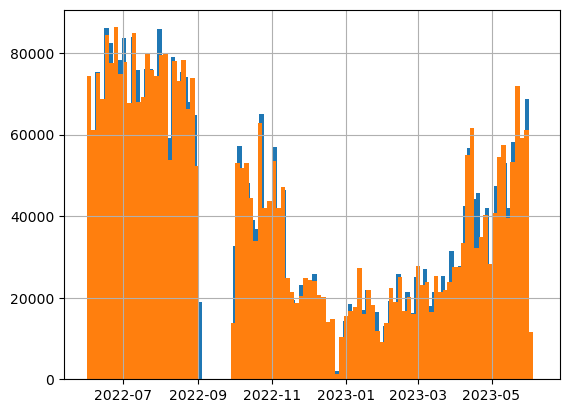

In [3]:
%matplotlib inline
bins=100
df['start'].hist(bins=bins)
df['stop'].hist(bins=bins)

That's weird; where's the September 2022 data?

In [4]:
df.dtypes

ride_id                            object
member_casual                      object
startdate                          object
starttime                          object
stopdate                           object
stoptime                           object
rideable_type                      object
tripduration                        int64
max_temperature_c                   int64
min_temperature_c                   int64
temperature_morning_c               int64
temperature_noon_c                  int64
temperature_evening_c               int64
temperature_night_c                 int64
precip_total_day_mm               float64
windspeed_max_kmh                   int64
cloudcover_avg_percent            float64
start                      datetime64[ns]
stop                       datetime64[ns]
duration                  timedelta64[ns]
dtype: object

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Axes: xlabel='start', ylabel='tripduration'>

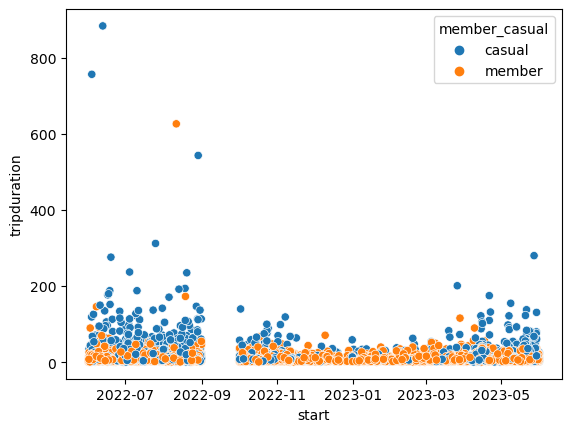

In [5]:
from seaborn import scatterplot
scatterplot(data=df.sample(5000), x='start', y='tripduration', hue='member_casual')

Let's get ready to model. We want to predict trip duration, so we don't want to include both the start and end times.

In [6]:
model_columns = ['member_casual', 'rideable_type',  'max_temperature_c',
       'min_temperature_c', 'temperature_morning_c', 'temperature_noon_c',
       'temperature_evening_c', 'temperature_night_c', 'precip_total_day_mm',
       'windspeed_max_kmh', 'cloudcover_avg_percent', 'start', 'tripduration',]
model_df = df[model_columns].copy(deep=True)
model_df.sample(5)

,member_casual,rideable_type,max_temperature_c,min_temperature_c,temperature_morning_c,temperature_noon_c,temperature_evening_c,temperature_night_c,precip_total_day_mm,windspeed_max_kmh,cloudcover_avg_percent,start,tripduration
1282422,member,electric_bike,8,5,7,8,5,8,0.4,16,63.500,2022-11-25 20:26:35,84
1161359,casual,electric_bike,25,21,22,23,25,22,2.6,20,50.625,2022-08-04 21:06:26,2
1054715,casual,electric_bike,32,21,21,31,30,21,0.0,23,3.250,2022-06-30 19:56:46,23
983531,member,classic_bike,30,20,20,29,30,20,0.0,25,21.750,2022-08-13 14:51:50,16
2373661,member,electric_bike,4,0,0,3,3,0,0.3,17,18.000,2023-01-07 08:43:59,7


It's called we do some feature engineering

In [7]:
model_df['year'] = model_df['start'].dt.year
model_df['month'] = model_df['start'].dt.month
model_df['day'] = model_df['start'].dt.day
model_df['day_of_week'] = model_df['start'].dt.day_of_week
model_df['hour_of_day'] = model_df['start'].dt.hour
model_df = pd.get_dummies(data=model_df.drop(columns=['start']), columns=['member_casual', 'rideable_type'])
model_df.sample(5)

,max_temperature_c,min_temperature_c,temperature_morning_c,temperature_noon_c,temperature_evening_c,temperature_night_c,precip_total_day_mm,windspeed_max_kmh,cloudcover_avg_percent,tripduration,year,month,day,day_of_week,hour_of_day,member_casual_casual,member_casual_member,rideable_type_classic_bike,rideable_type_docked_bike,rideable_type_electric_bike
989806,8,4,4,5,7,4,0.1,9,92.750,27,2023,1,2,0,18,0,1,1,0,0
361436,24,18,18,22,24,18,0.5,13,52.500,16,2022,8,21,6,0,1,0,1,0,0
592681,1,-2,-1,0,-1,0,0.2,27,88.625,2,2022,11,17,3,8,0,1,1,0,0
132117,4,1,1,3,4,2,1.7,35,95.125,9,2023,4,17,0,14,0,1,0,0,1
212236,30,19,19,29,28,20,0.0,12,0.000,15,2022,8,5,4,20,0,1,1,0,0


In [8]:
model_df.dtypes

max_temperature_c                int64
min_temperature_c                int64
temperature_morning_c            int64
temperature_noon_c               int64
temperature_evening_c            int64
temperature_night_c              int64
precip_total_day_mm            float64
windspeed_max_kmh                int64
cloudcover_avg_percent         float64
tripduration                     int64
year                             int64
month                            int64
day                              int64
day_of_week                      int64
hour_of_day                      int64
member_casual_casual             uint8
member_casual_member             uint8
rideable_type_classic_bike       uint8
rideable_type_docked_bike        uint8
rideable_type_electric_bike      uint8
dtype: object